In [1]:
## BUSINESS USE CASE -- PLANE CRASHES HAPPEN!! HERE'S HOW YOU CAN AVOID DYING!!

In [92]:
import csv
import pickle
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from collections import Counter
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

from __future__ import print_function, division

# Get pandas and postgres to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql
plt.rc('font', size=18) 

In [3]:
with open('airline_crash.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [4]:
state_df = pd.concat([df['Event_Id'], df['Location'].str.split(', ', expand=True)], axis=1)

In [5]:
state_df['City'] = state_df[0]
state_df['State'] = state_df[1]

state_df = state_df.drop([0,1,2,3,4],1)

In [6]:
df.reset_index(inplace=True)
state_df.reset_index(inplace=True)

In [7]:
df = pd.merge(df, state_df, on='index')

df = df.drop(['Location'],1)

In [8]:
df.Latitude = df.Latitude.astype('float')
df.Longitude = df.Longitude.astype('float')
df.Total_Fatal_Injuries = df.Total_Fatal_Injuries.astype('float')
df.Total_Serious_Injuries = df.Total_Serious_Injuries.astype('float')
df.Total_Minor_Injuries = df.Total_Minor_Injuries.astype('float')
df.Total_Uninjured = df.Total_Uninjured.astype('float')
df.Number_Engines = df.Number_Engines.astype('float')

df['Event_Date'] = pd.to_datetime(df['Event_Date'])

In [9]:
df.head()

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
0,0,20180719X01751,Accident,CEN18LA281,2018-07-19,United States,32.540277,-93.745000,DTN,Shreveport Executive,...,NaN,NaN,1.0,VMC,MANEUVERING,Preliminary,07/23/2018,20180719X01751,Shreveport,LA
1,1,20180717X23051,Accident,GAA18CA428,2018-07-17,United States,36.124445,-86.678056,BNA,Nashville Intl,...,NaN,NaN,NaN,VMC,NaN,Preliminary,07/19/2018,20180717X23051,Nashville,TN
2,2,20180717X82154,Accident,CEN18LA276,2018-07-17,United States,29.868056,-95.795000,IWS,West Houston,...,NaN,NaN,1.0,VMC,NaN,Preliminary,07/19/2018,20180717X82154,Katy,TX
3,3,20180716X44947,Accident,GAA18CA427,2018-07-16,United States,26.002222,-80.240000,HWO,NORTH PERRY,...,NaN,1.0,NaN,VMC,NaN,Preliminary,07/23/2018,20180716X44947,Hollywood,FL
4,4,20180716X60511,Accident,GAA18CA424,2018-07-16,United States,39.564722,-85.235555,N/A,NaN,...,NaN,1.0,NaN,NaN,NaN,Preliminary,07/19/2018,20180716X60511,New Castle,IN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81899 entries, 0 to 81898
Data columns (total 34 columns):
index                     81899 non-null int64
Event_Id_x                81899 non-null object
Investigation_Type        81899 non-null object
Accident_Number           81899 non-null object
Event_Date                81899 non-null datetime64[ns]
Country                   81392 non-null object
Latitude                  28059 non-null float64
Longitude                 28050 non-null float64
Airport_Code              46449 non-null object
Airport_Name              51554 non-null object
Injury_Severity           81899 non-null object
Aircraft_Damage           79321 non-null object
Aircraft_Category         25157 non-null object
Registration_Number       78414 non-null object
Make                      81828 non-null object
Model                     81800 non-null object
Amateur_Built             81267 non-null object
Number_Engines            77419 non-null float64
Engine_Type      

In [11]:
df.Broad_Phase_of_Flight.value_counts()

LANDING        19925
TAKEOFF        15767
CRUISE         10911
MANEUVERING    10115
APPROACH        7940
TAXI            2401
CLIMB           2333
DESCENT         2264
GO-AROUND       1667
STANDING        1262
UNKNOWN          738
OTHER            164
Name: Broad_Phase_of_Flight, dtype: int64

In [12]:
df.Broad_Phase_of_Flight.replace('CRUISE', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('MANEUVERING', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('GO-AROUND', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('APPROACH', 'LANDING', inplace=True)
df.Broad_Phase_of_Flight.replace('DESCENT', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('CLIMB', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('STANDING', 'TAXI', inplace=True)

In [13]:
df.Broad_Phase_of_Flight.value_counts()

LANDING     27865
INFLIGHT    27290
TAKEOFF     15767
TAXI         3663
UNKNOWN       738
OTHER         164
Name: Broad_Phase_of_Flight, dtype: int64

In [14]:
df = df[df['Broad_Phase_of_Flight'] != 'OTHER']
df = df[df['Broad_Phase_of_Flight'] != 'UNKNOWN']

In [15]:
df.Broad_Phase_of_Flight.value_counts()

LANDING     27865
INFLIGHT    27290
TAKEOFF     15767
TAXI         3663
Name: Broad_Phase_of_Flight, dtype: int64

In [16]:
df = df.rename(columns={'Event_Id_x': 'Event_Id'})

df = df.drop(['Event_Id_y'], axis=1)

In [17]:
len(df.Aircraft_Category.unique())

13

In [18]:
real_df = df.dropna(subset=['Investigation_Type','Event_Date',
              'Country', 'Injury_Severity', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State'])

real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46843 entries, 16185 to 81898
Data columns (total 33 columns):
index                     46843 non-null int64
Event_Id                  46843 non-null object
Investigation_Type        46843 non-null object
Accident_Number           46843 non-null object
Event_Date                46843 non-null datetime64[ns]
Country                   46843 non-null object
Latitude                  288 non-null float64
Longitude                 288 non-null float64
Airport_Code              25732 non-null object
Airport_Name              27910 non-null object
Injury_Severity           46843 non-null object
Aircraft_Damage           45929 non-null object
Aircraft_Category         3689 non-null object
Registration_Number       46843 non-null object
Make                      46836 non-null object
Model                     46823 non-null object
Amateur_Built             46843 non-null object
Number_Engines            46843 non-null float64
Engine_Type       

In [19]:
real_df.Aircraft_Category.value_counts()

Airplane      3270
Helicopter     318
Glider          52
Balloon         30
Gyrocraft       17
Unknown          1
Ultralight       1
Name: Aircraft_Category, dtype: int64

In [20]:
real_df.Weather_Condition.value_counts()

VMC    42649
IMC     3755
UNK      439
Name: Weather_Condition, dtype: int64

In [21]:
real_df = real_df[real_df['Weather_Condition'] != 'UNK']

In [22]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46404 entries, 16185 to 81895
Data columns (total 33 columns):
index                     46404 non-null int64
Event_Id                  46404 non-null object
Investigation_Type        46404 non-null object
Accident_Number           46404 non-null object
Event_Date                46404 non-null datetime64[ns]
Country                   46404 non-null object
Latitude                  288 non-null float64
Longitude                 288 non-null float64
Airport_Code              25612 non-null object
Airport_Name              27779 non-null object
Injury_Severity           46404 non-null object
Aircraft_Damage           45507 non-null object
Aircraft_Category         3638 non-null object
Registration_Number       46404 non-null object
Make                      46397 non-null object
Model                     46384 non-null object
Amateur_Built             46404 non-null object
Number_Engines            46404 non-null float64
Engine_Type       

In [23]:
real_df = real_df[['Event_Id','Investigation_Type','Event_Date',
              'Country', 'Injury_Severity', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State']]

In [24]:
real_df.State.value_counts()

CA                                5292
AK                                3342
TX                                3183
FL                                3175
CO                                1497
WA                                1443
AZ                                1373
IL                                1235
MI                                1222
NY                                1109
OH                                1068
GA                                1064
PA                                1051
AR                                 988
OR                                 955
MO                                 954
WI                                 884
NC                                 877
MN                                 838
IN                                 793
OK                                 764
LA                                 729
NM                                 721
AL                                 682
NJ                                 680
VA                       

In [25]:
real_df['Total_Passengers'] = (real_df['Total_Fatal_Injuries'] + real_df['Total_Serious_Injuries'] + 
                                real_df['Total_Minor_Injuries'] + real_df['Total_Uninjured'])

In [26]:
real_df['Total_Passengers'].value_counts()

1.0      20672
2.0      15012
3.0       4343
4.0       3154
5.0        915
6.0        508
7.0        210
8.0        133
10.0        67
9.0         61
11.0        47
12.0        39
16.0        30
14.0        25
18.0        25
20.0        21
21.0        20
13.0        17
15.0        17
17.0        15
22.0        12
33.0        12
53.0        12
96.0        11
26.0        10
108.0       10
24.0        10
87.0        10
131.0       10
127.0       10
         ...  
199.0        1
205.0        1
305.0        1
171.0        1
225.0        1
200.0        1
412.0        1
187.0        1
390.0        1
231.0        1
260.0        1
436.0        1
209.0        1
411.0        1
195.0        1
262.0        1
269.0        1
206.0        1
283.0        1
251.0        1
306.0        1
173.0        1
481.0        1
265.0        1
126.0        1
257.0        1
253.0        1
246.0        1
277.0        1
216.0        1
Name: Total_Passengers, Length: 293, dtype: int64

In [27]:
def solo_flight(row):
    if row['Total_Passengers'] == 1 :
        return 'Yes'
    else:
        return 'No'

In [28]:
real_df.apply(lambda row: solo_flight(row),axis=1)

16185     No
16254     No
16315     No
16337    Yes
16369    Yes
16370     No
16395    Yes
16412     No
16418     No
16438    Yes
16472     No
16474     No
16480    Yes
16507    Yes
16540     No
16546     No
16569    Yes
16571     No
16592    Yes
16600    Yes
16621     No
16667    Yes
16674     No
16733    Yes
16802     No
16850     No
16851     No
16857     No
16862    Yes
16895     No
        ... 
81861     No
81862     No
81864     No
81865     No
81866     No
81867     No
81868     No
81869    Yes
81870     No
81871     No
81872     No
81873    Yes
81874     No
81875    Yes
81876    Yes
81877     No
81878    Yes
81879    Yes
81880    Yes
81881     No
81882    Yes
81883    Yes
81884     No
81885    Yes
81887     No
81888     No
81889     No
81890    Yes
81891    Yes
81895     No
Length: 46404, dtype: object

In [29]:
real_df['Solo_Flight'] = real_df.apply(lambda row: solo_flight(row),axis=1)

In [30]:
real_df['Solo_Flight'].value_counts()

No     25732
Yes    20672
Name: Solo_Flight, dtype: int64

In [31]:
real_df['Flight_Purpose'].value_counts()

Personal                     26591
Instructional                 5768
Unknown                       5276
Aerial Application            3029
Business                      2820
Positioning                    739
Other Work Use                 593
Ferry                          556
Executive/Corporate            350
Public Aircraft                337
Aerial Observation             322
Flight Test                      9
Air Race/Show                    3
Skydiving                        3
External Load                    3
Public Aircraft - Local          2
Public Aircraft - Federal        1
Glider Tow                       1
Public Aircraft - State          1
Name: Flight_Purpose, dtype: int64

In [32]:
real_df.Flight_Purpose.replace('Unknown', 'Other', inplace=True)
real_df.Flight_Purpose.replace('Executive/Corporate', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Aerial Observation', 'Aerial Application', inplace=True)
real_df.Flight_Purpose.replace('Flight Test', 'Instructional', inplace=True)
real_df.Flight_Purpose.replace('Air Race/Show', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Skydiving', 'Business', inplace=True)
real_df.Flight_Purpose.replace('External Load', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Local', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Other Work Use', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Federal', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Glider Tow', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - State', 'Business', inplace=True)

In [33]:
real_df['Flight_Purpose'].value_counts()

Personal              26591
Instructional          5777
Other                  5276
Business               4114
Aerial Application     3351
Positioning             739
Ferry                   556
Name: Flight_Purpose, dtype: int64

In [34]:
real_df['Was_Fatal'] = real_df['Total_Fatal_Injuries']

fatal = np.array(real_df['Was_Fatal'].values.tolist())

In [35]:
real_df['Was_Fatal'] = np.where(fatal > 0, 'Fatal', fatal).tolist()

In [36]:
new_fatal = np.array(real_df['Was_Fatal'].values.tolist())

new_fatal

array(['0.0', '0.0', '0.0', ..., '0.0', '0.0', 'Fatal'], dtype='<U5')

In [37]:
real_df['Was_Fatal'] = np.where(new_fatal == '0.0', 'Non-fatal', new_fatal).tolist()

In [38]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Solo_Flight,Was_Fatal
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,No,1.0,Reciprocating,Personal,0.0,1.0,1.0,0.0,VMC,INFLIGHT,Monterey,CA,2.0,No,Non-fatal
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,No,1.0,Reciprocating,Instructional,0.0,0.0,0.0,2.0,VMC,TAKEOFF,Nacogdoches,TX,2.0,No,Non-fatal
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Yes,1.0,Reciprocating,Personal,0.0,2.0,0.0,0.0,VMC,INFLIGHT,Breckenridge,TX,2.0,No,Non-fatal
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,No,1.0,Reciprocating,Personal,0.0,0.0,0.0,1.0,VMC,LANDING,Angleton,TX,1.0,Yes,Non-fatal
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,No,1.0,Turbo Shaft,Business,0.0,1.0,0.0,0.0,VMC,INFLIGHT,Cougar,WA,1.0,Yes,Non-fatal


In [39]:
real_df['Was_Fatal'].value_counts()

Non-fatal    38118
Fatal         8286
Name: Was_Fatal, dtype: int64

In [40]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46404 entries, 16185 to 81895
Data columns (total 20 columns):
Event_Id                  46404 non-null object
Investigation_Type        46404 non-null object
Event_Date                46404 non-null datetime64[ns]
Country                   46404 non-null object
Injury_Severity           46404 non-null object
Amateur_Built             46404 non-null object
Number_Engines            46404 non-null float64
Engine_Type               46404 non-null object
Flight_Purpose            46404 non-null object
Total_Fatal_Injuries      46404 non-null float64
Total_Serious_Injuries    46404 non-null float64
Total_Minor_Injuries      46404 non-null float64
Total_Uninjured           46404 non-null float64
Weather_Condition         46404 non-null object
Broad_Phase_of_Flight     46404 non-null object
City                      46404 non-null object
State                     46404 non-null object
Total_Passengers          46404 non-null float64
Solo_Flig

In [41]:
real_df['Month'] = real_df['Event_Date'].dt.month

In [42]:
real_df.Month.value_counts()

7     5603
8     5279
6     4962
5     4515
9     4368
4     3874
3     3512
10    3504
11    2850
2     2772
12    2595
1     2570
Name: Month, dtype: int64

In [43]:
real_df['Season'] = ((real_df['Month']%12 + 3)//3)

real_df.Season.value_counts()

3    15844
2    11901
4    10722
1     7937
Name: Season, dtype: int64

In [44]:
real_df.Season.replace(1, 'Winter', inplace=True)
real_df.Season.replace(2, 'Spring', inplace=True)
real_df.Season.replace(3, 'Summer', inplace=True)
real_df.Season.replace(4, 'Fall', inplace=True)

In [45]:
real_df.Season.value_counts()

Summer    15844
Spring    11901
Fall      10722
Winter     7937
Name: Season, dtype: int64

In [46]:
fatal_crash_df = real_df[real_df['Was_Fatal'] == 'Fatal']

In [47]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46404 entries, 16185 to 81895
Data columns (total 22 columns):
Event_Id                  46404 non-null object
Investigation_Type        46404 non-null object
Event_Date                46404 non-null datetime64[ns]
Country                   46404 non-null object
Injury_Severity           46404 non-null object
Amateur_Built             46404 non-null object
Number_Engines            46404 non-null float64
Engine_Type               46404 non-null object
Flight_Purpose            46404 non-null object
Total_Fatal_Injuries      46404 non-null float64
Total_Serious_Injuries    46404 non-null float64
Total_Minor_Injuries      46404 non-null float64
Total_Uninjured           46404 non-null float64
Weather_Condition         46404 non-null object
Broad_Phase_of_Flight     46404 non-null object
City                      46404 non-null object
State                     46404 non-null object
Total_Passengers          46404 non-null float64
Solo_Flig

In [48]:
relative_season_impact = pd.value_counts(fatal_crash_df['Season']) / pd.value_counts(real_df['Season'])

Text(0.5,1,'Fatal Accidents by Season')

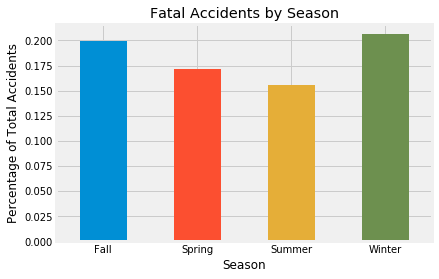

In [49]:
relative_season_impact.plot.bar()
plt.xlabel('Season')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=0)
plt.title("Fatal Accidents by Season")

## Fall and winter have the relatively highest fatal accidents!

In [50]:
amatuer_build_impact = pd.value_counts(fatal_crash_df['Amateur_Built']) / pd.value_counts(real_df['Amateur_Built'])

Text(0.5,1,'Fatal Accidents by Amatuer Built')

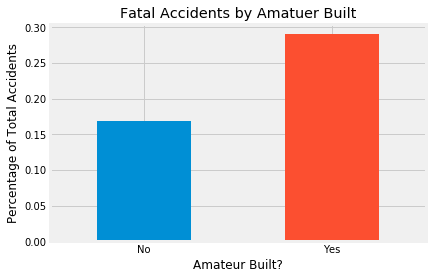

In [51]:
amatuer_build_impact.plot.bar()
plt.xlabel('Amateur Built?')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=0)
plt.title("Fatal Accidents by Amatuer Built")

In [52]:
flight_purpose_impact = pd.value_counts(fatal_crash_df['Flight_Purpose']) / pd.value_counts(real_df['Flight_Purpose'])

Text(0.5,1,'Fatal Accidents by Flight Purpose')

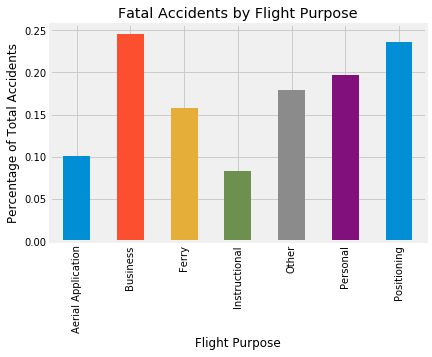

In [53]:
flight_purpose_impact.plot.bar()
plt.xlabel('Flight Purpose')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by Flight Purpose")

In [54]:
weather_impact = pd.value_counts(fatal_crash_df['Weather_Condition']) / pd.value_counts(real_df['Weather_Condition'])

Text(0.5,1,'Fatal Accidents by Weather Condition')

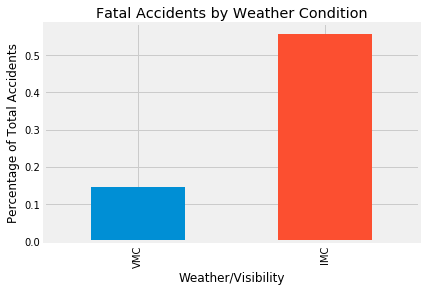

In [55]:
weather_impact.plot.bar()
plt.xlabel('Weather/Visibility')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by Weather Condition")

In [56]:
flight_phase_impact = pd.value_counts(fatal_crash_df['Broad_Phase_of_Flight']) / pd.value_counts(real_df['Broad_Phase_of_Flight'])

Text(0.5,1,'Fatal Accidents by flight phase')

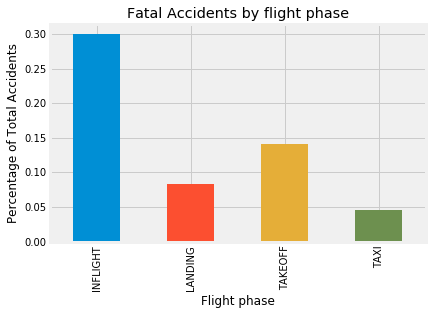

In [57]:
flight_phase_impact.plot.bar()
plt.xlabel('Flight phase')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by flight phase")

In [58]:
# aircraft_category_impact = pd.value_counts(fatal_crash_df['Aircraft_Category']) / pd.value_counts(real_df['Aircraft_Category'])

In [59]:
# aircraft_category_impact.plot.bar()
# plt.xlabel('Aircraft Category')
# plt.ylabel('Percentage of Total Accidents')
# plt.xticks(rotation=90)
# plt.title("Fatal Accidents by aircraft category")

In [60]:
solo_flight_impact = pd.value_counts(fatal_crash_df['Solo_Flight']) / pd.value_counts(real_df['Solo_Flight'])

Text(0.5,1,'Fatal Accidents by solo flight')

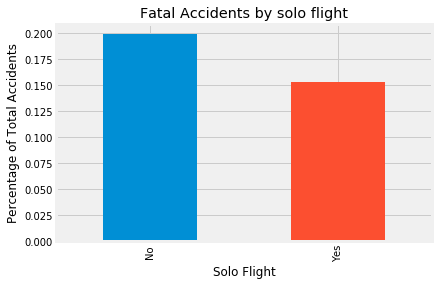

In [61]:
solo_flight_impact.plot.bar()
plt.xlabel('Solo Flight')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by solo flight")

In [62]:
engine_type_impact = pd.value_counts(fatal_crash_df['Engine_Type']) / pd.value_counts(real_df['Engine_Type'])

Text(0.5,1,'Fatal Accidents by engine type')

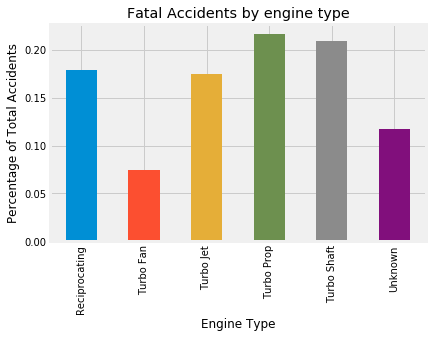

In [63]:
engine_type_impact.plot.bar()
plt.xlabel('Engine Type')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by engine type")

In [64]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46404 entries, 16185 to 81895
Data columns (total 22 columns):
Event_Id                  46404 non-null object
Investigation_Type        46404 non-null object
Event_Date                46404 non-null datetime64[ns]
Country                   46404 non-null object
Injury_Severity           46404 non-null object
Amateur_Built             46404 non-null object
Number_Engines            46404 non-null float64
Engine_Type               46404 non-null object
Flight_Purpose            46404 non-null object
Total_Fatal_Injuries      46404 non-null float64
Total_Serious_Injuries    46404 non-null float64
Total_Minor_Injuries      46404 non-null float64
Total_Uninjured           46404 non-null float64
Weather_Condition         46404 non-null object
Broad_Phase_of_Flight     46404 non-null object
City                      46404 non-null object
State                     46404 non-null object
Total_Passengers          46404 non-null float64
Solo_Flig

In [65]:
dummy_df = real_df[['Season', 'Amateur_Built', 'Engine_Type',
                    'Flight_Purpose', 'Weather_Condition', 'Broad_Phase_of_Flight', 'Solo_Flight']]

In [66]:
dummy_df = pd.get_dummies(dummy_df)

In [67]:
# dummy_df.reset_index(inplace=True)
# real_df.reset_index(inplace=True)

In [68]:
dummy_df.head()

,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Amateur_Built_No,Amateur_Built_Yes,Engine_Type_Reciprocating,Engine_Type_Turbo Fan,Engine_Type_Turbo Jet,Engine_Type_Turbo Prop,...,Flight_Purpose_Personal,Flight_Purpose_Positioning,Weather_Condition_IMC,Weather_Condition_VMC,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes
16185,1,0,0,0,1,0,1,0,0,0,...,1,0,0,1,1,0,0,0,1,0
16254,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0
16315,1,0,0,0,0,1,1,0,0,0,...,1,0,0,1,1,0,0,0,1,0
16337,1,0,0,0,1,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,1
16369,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1


In [69]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,Total_Fatal_Injuries,...,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Solo_Flight,Was_Fatal,Month,Season
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,No,1.0,Reciprocating,Personal,0.0,...,0.0,VMC,INFLIGHT,Monterey,CA,2.0,No,Non-fatal,11,Fall
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,No,1.0,Reciprocating,Instructional,0.0,...,2.0,VMC,TAKEOFF,Nacogdoches,TX,2.0,No,Non-fatal,11,Fall
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Yes,1.0,Reciprocating,Personal,0.0,...,0.0,VMC,INFLIGHT,Breckenridge,TX,2.0,No,Non-fatal,10,Fall
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,No,1.0,Reciprocating,Personal,0.0,...,1.0,VMC,LANDING,Angleton,TX,1.0,Yes,Non-fatal,10,Fall
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,No,1.0,Turbo Shaft,Business,0.0,...,0.0,VMC,INFLIGHT,Cougar,WA,1.0,Yes,Non-fatal,10,Fall


In [70]:
real_df = real_df.join(dummy_df)

In [71]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,Total_Fatal_Injuries,...,Flight_Purpose_Personal,Flight_Purpose_Positioning,Weather_Condition_IMC,Weather_Condition_VMC,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,No,1.0,Reciprocating,Personal,0.0,...,1,0,0,1,1,0,0,0,1,0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,No,1.0,Reciprocating,Instructional,0.0,...,0,0,0,1,0,0,1,0,1,0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Yes,1.0,Reciprocating,Personal,0.0,...,1,0,0,1,1,0,0,0,1,0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,No,1.0,Reciprocating,Personal,0.0,...,1,0,0,1,0,1,0,0,0,1
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,No,1.0,Turbo Shaft,Business,0.0,...,0,0,0,1,1,0,0,0,0,1


In [72]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46404 entries, 16185 to 81895
Data columns (total 49 columns):
Event_Id                             46404 non-null object
Investigation_Type                   46404 non-null object
Event_Date                           46404 non-null datetime64[ns]
Country                              46404 non-null object
Injury_Severity                      46404 non-null object
Amateur_Built                        46404 non-null object
Number_Engines                       46404 non-null float64
Engine_Type                          46404 non-null object
Flight_Purpose                       46404 non-null object
Total_Fatal_Injuries                 46404 non-null float64
Total_Serious_Injuries               46404 non-null float64
Total_Minor_Injuries                 46404 non-null float64
Total_Uninjured                      46404 non-null float64
Weather_Condition                    46404 non-null object
Broad_Phase_of_Flight                46404 non-n

In [73]:
real_df.columns

Index(['Event_Id', 'Investigation_Type', 'Event_Date', 'Country',
       'Injury_Severity', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
       'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
       'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition',
       'Broad_Phase_of_Flight', 'City', 'State', 'Total_Passengers',
       'Solo_Flight', 'Was_Fatal', 'Month', 'Season', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'Amateur_Built_No',
       'Amateur_Built_Yes', 'Engine_Type_Reciprocating',
       'Engine_Type_Turbo Fan', 'Engine_Type_Turbo Jet',
       'Engine_Type_Turbo Prop', 'Engine_Type_Turbo Shaft',
       'Engine_Type_Unknown', 'Flight_Purpose_Aerial Application',
       'Flight_Purpose_Business', 'Flight_Purpose_Ferry',
       'Flight_Purpose_Instructional', 'Flight_Purpose_Other',
       'Flight_Purpose_Personal', 'Flight_Purpose_Positioning',
       'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad

In [74]:
target_count = real_df['Was_Fatal'].value_counts()
print(f'Non-Fatal: {target_count[0]}')
print(f'Fatal: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Non-Fatal: 38118
Fatal: 8286
Proportion: 4.6 : 1
Percentage of Majority Class: 82.14


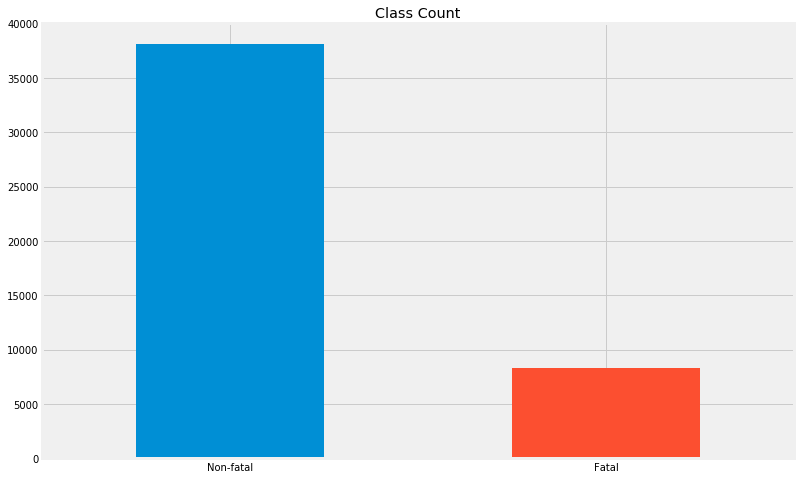

In [75]:
target_count.plot(kind='bar', title='Class Count', rot=0);
plt.gcf().set_size_inches(12,8)

In [76]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

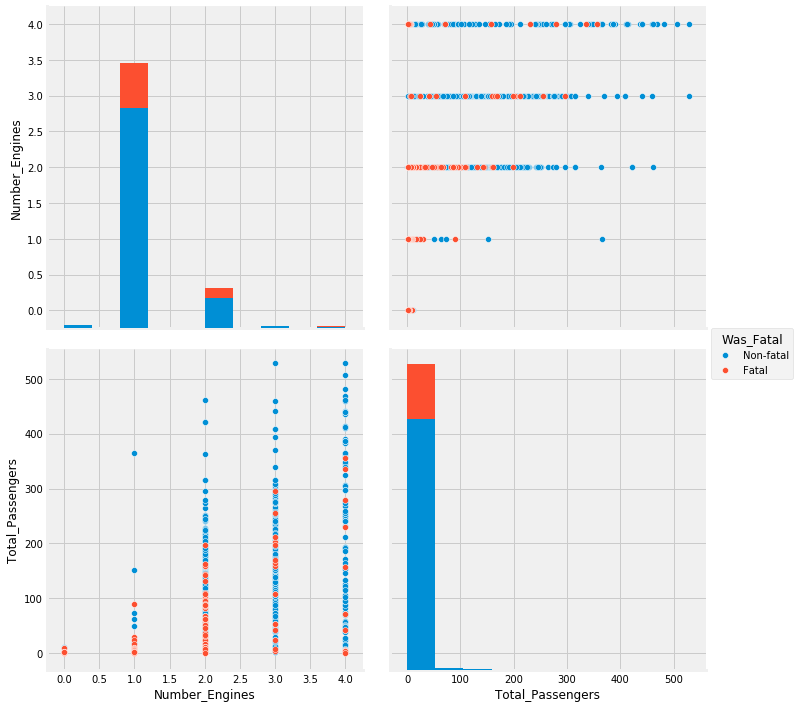

In [77]:
numerical_df = real_df[['Number_Engines','Total_Passengers','Was_Fatal']]

sns.pairplot(numerical_df, hue='Was_Fatal', size=5);

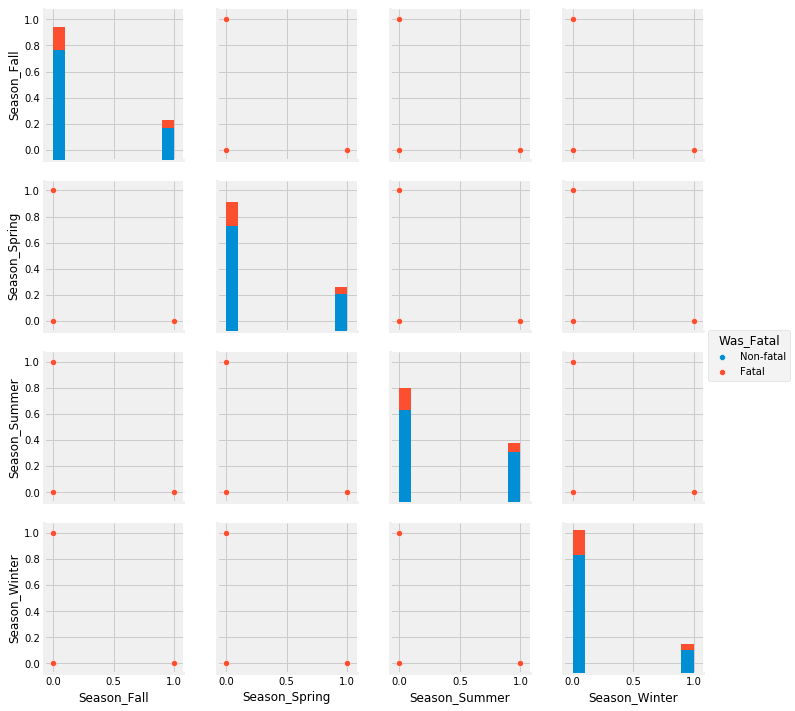

In [78]:
season_df = real_df[['Was_Fatal','Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter']]

sns.pairplot(season_df, hue='Was_Fatal');

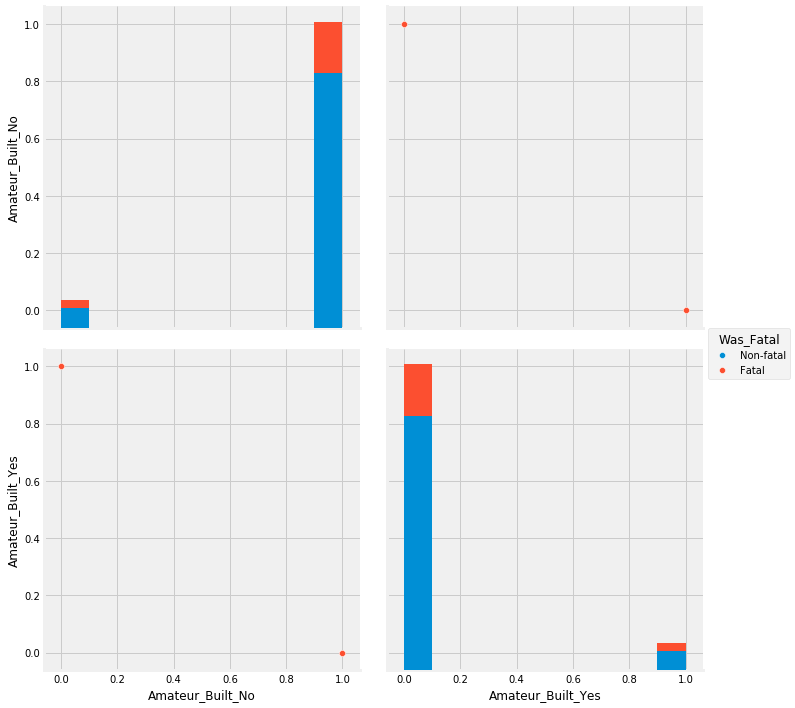

In [79]:
amateur_df = real_df[['Was_Fatal','Amateur_Built_No', 'Amateur_Built_Yes']]

sns.pairplot(amateur_df, hue='Was_Fatal', size=5);

# END OF EDA / START OF ANALYSIS

In [80]:
y = real_df['Was_Fatal']
X = real_df[['Number_Engines','Total_Passengers', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [81]:
X_train.head()

,Number_Engines,Total_Passengers,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Amateur_Built_No,Amateur_Built_Yes,Engine_Type_Reciprocating,Engine_Type_Turbo Fan,...,Flight_Purpose_Personal,Flight_Purpose_Positioning,Weather_Condition_IMC,Weather_Condition_VMC,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes
72375,1.0,5.0,0,0,1,0,1,0,1,0,...,1,0,0,1,0,0,0,1,1,0
60461,1.0,2.0,1,0,0,0,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
52151,1.0,2.0,0,0,0,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
64397,1.0,1.0,0,1,0,0,1,0,1,0,...,0,0,0,1,1,0,0,0,0,1
35226,1.0,1.0,0,0,1,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,1


In [82]:
ssX = StandardScaler()
X_train_scalable = X_train.filter(['Number_Engines','Total_Passengers'], axis=1)
X_train_scaled_columns = pd.DataFrame(ssX.fit_transform(X_train_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_train.reset_index(inplace=True)
X_train = X_train.join(X_train_scaled_columns)
X_train = X_train.drop(['Number_Engines','Total_Passengers'],1)

X_train = X_train.set_index('index')

X_test_scalable = X_FINALtest.filter(['Number_Engines','Total_Passengers'], axis=1)
X_test_scaled_columns = pd.DataFrame(ssX.transform(X_test_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_FINALtest.reset_index(inplace=True)
X_FINALtest = X_FINALtest.join(X_test_scaled_columns)
X_FINALtest = X_FINALtest.drop(['Number_Engines','Total_Passengers'],1)

X_FINALtest = X_FINALtest.set_index('index')

In [83]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34803 entries, 72375 to 70075
Data columns (total 29 columns):
Season_Fall                          34803 non-null uint8
Season_Spring                        34803 non-null uint8
Season_Summer                        34803 non-null uint8
Season_Winter                        34803 non-null uint8
Amateur_Built_No                     34803 non-null uint8
Amateur_Built_Yes                    34803 non-null uint8
Engine_Type_Reciprocating            34803 non-null uint8
Engine_Type_Turbo Fan                34803 non-null uint8
Engine_Type_Turbo Jet                34803 non-null uint8
Engine_Type_Turbo Prop               34803 non-null uint8
Engine_Type_Turbo Shaft              34803 non-null uint8
Engine_Type_Unknown                  34803 non-null uint8
Flight_Purpose_Aerial Application    34803 non-null uint8
Flight_Purpose_Business              34803 non-null uint8
Flight_Purpose_Ferry                 34803 non-null uint8
Flight_Purpose_In

In [84]:
X_FINALtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11601 entries, 47509 to 54324
Data columns (total 29 columns):
Season_Fall                          11601 non-null uint8
Season_Spring                        11601 non-null uint8
Season_Summer                        11601 non-null uint8
Season_Winter                        11601 non-null uint8
Amateur_Built_No                     11601 non-null uint8
Amateur_Built_Yes                    11601 non-null uint8
Engine_Type_Reciprocating            11601 non-null uint8
Engine_Type_Turbo Fan                11601 non-null uint8
Engine_Type_Turbo Jet                11601 non-null uint8
Engine_Type_Turbo Prop               11601 non-null uint8
Engine_Type_Turbo Shaft              11601 non-null uint8
Engine_Type_Unknown                  11601 non-null uint8
Flight_Purpose_Aerial Application    11601 non-null uint8
Flight_Purpose_Business              11601 non-null uint8
Flight_Purpose_Ferry                 11601 non-null uint8
Flight_Purpose_In

In [85]:
## THIS IS JUST USING DEFAULTS FOR EACH TYPE -- NEED TO TUNE HYPERPARAMETERS

X_temptrain, X_temptest, y_temptrain, y_temptest = train_test_split(X_train, y_train, test_size=0.3, random_state=4444)

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):    
    models[i].fit(X_temptrain, y_temptrain)
    y_predict = models[i].predict(X_temptest)
    accuracy = np.round(accuracy_score(y_temptest, y_predict), 4)
    precision = np.round(precision_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    recall = np.round(recall_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    f1 = np.round(f1_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    print(f'{names[i]} acc: {accuracy} prec: {precision} recall: {recall} f1-score: {f1}')
    print('')

LR acc: 0.8429 prec: 0.6654 recall: 0.1949 f1-score: 0.3015

KNN acc: 0.8245 prec: 0.4902 recall: 0.2208 f1-score: 0.3045

NB acc: 0.7445 prec: 0.3575 recall: 0.5887 f1-score: 0.4449

SVC acc: 0.839 prec: 0.6006 recall: 0.2219 f1-score: 0.3241

Decision Tree acc: 0.8251 prec: 0.495 recall: 0.272 f1-score: 0.3511

Random Forest acc: 0.8293 prec: 0.52 recall: 0.2439 f1-score: 0.3321

Gradient Boosted Trees acc: 0.8434 prec: 0.6591 recall: 0.2065 f1-score: 0.3145



In [86]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.8263368100451111, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')
logistic: best score: 0.8382036031376605, best estimator: LogisticRegression(C=0.006579332246575682, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.8387207999310404, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.8391805304140447, b

In [87]:
from sklearn.feature_selection import SelectKBest, RFE, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

def feature_selection(X, y, count):

    # Feature Importance from Random Forest
    ET = ExtraTreesClassifier()
    ET.fit(X, y)    
    importances = list(zip(ET.feature_importances_, X.columns))
    importances.sort(reverse=True)
    FI_features = [x[1] for x in importances][0:count]

    # Recursive Feature Elimination
    lm1 = LogisticRegression()
    rfe = RFE(lm1, count)
    fit = rfe.fit(X, y)
    RFE_features = list(X.columns[fit.support_])

    # PCA
#     pca = PCA(n_components=5)
#     fit = pca.fit(X)    
#     df = pd.DataFrame(pca.components_,columns=X.columns).abs().mean().sort_values(ascending = False)
#     PCA_features = list(df.index.values)[0:7]
    
    feats = pd.DataFrame(
        {
         'Feature_Importance': FI_features,
         'RFE': RFE_features,
#          'PCA': PCA_features
        })
    
    return feats

In [88]:
feature_selection(X_train, y_train, 20)

,Feature_Importance,RFE
0,Total_Passengers_Scaled,Season_Summer
1,Broad_Phase_of_Flight_INFLIGHT,Amateur_Built_No
2,Weather_Condition_IMC,Amateur_Built_Yes
3,Weather_Condition_VMC,Engine_Type_Reciprocating
4,Number_Engines_Scaled,Engine_Type_Turbo Fan
5,Broad_Phase_of_Flight_LANDING,Engine_Type_Turbo Jet
6,Broad_Phase_of_Flight_TAKEOFF,Engine_Type_Unknown
7,Amateur_Built_No,Flight_Purpose_Aerial Application
8,Engine_Type_Reciprocating,Flight_Purpose_Business
9,Amateur_Built_Yes,Flight_Purpose_Ferry


In [89]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.8382036031376605, best estimator: LogisticRegression(C=0.006579332246575682, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [93]:
lm1 = grid.best_estimator_
lm1.fit(X_train, y_train)

LogisticRegression(C=0.006579332246575682, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [94]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_train):

    kX_train = X_train.iloc[train_index]
    kX_test = X_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = lm1.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with Unbalanced Data -- Logistic Regress MVP')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with Unbalanced Data -- Logistic Regress MVP
Logistic Regress accuracy: 0.8382 precision: 0.6754 recall: 0.1808 f1: 0.2852 fB: 0.2118



In [95]:
columns = ['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

coef_viewer = {}
for col, score in zip(columns, lm1.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Amateur_Built_No                     0.029500
Amateur_Built_Yes                    0.201813
Broad_Phase_of_Flight_INFLIGHT       0.051650
Broad_Phase_of_Flight_LANDING        0.354439
Broad_Phase_of_Flight_TAKEOFF       -0.010469
Broad_Phase_of_Flight_TAXI           0.295414
Engine_Type_Reciprocating            0.012284
Engine_Type_Turbo Fan                0.003341
Engine_Type_Turbo Jet                0.049894
Engine_Type_Turbo Prop              -0.011886
Engine_Type_Turbo Shaft              0.335452
Engine_Type_Unknown                 -0.183484
Flight_Purpose_Aerial Application    0.059134
Flight_Purpose_Business              0.290558
Flight_Purpose_Ferry                 0.052080
Flight_Purpose_Instructional        -0.123479
Flight_Purpose_Other                -0.145318
Flight_Purpose_Personal             -0.655913
Flight_Purpose_Positioning           0.940857
Number_Engines                      -0.038579
Season_Fall                          0.155878
Season_Spring                     

In [96]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.8390368646381059, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [97]:
rf = grid.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [98]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_train):

    kX_train = X_train.iloc[train_index]
    kX_test = X_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with Unbalanced Data -- RF MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with Unbalanced Data -- RF MVP
RF MVP accuracy: 0.8387 precision: 0.695 recall: 0.1726 f1: 0.2765 fB: 0.2032



In [99]:
columns = ['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Amateur_Built_No                     0.009250
Amateur_Built_Yes                    0.005535
Broad_Phase_of_Flight_INFLIGHT       0.017862
Broad_Phase_of_Flight_LANDING        0.016090
Broad_Phase_of_Flight_TAKEOFF        0.008681
Broad_Phase_of_Flight_TAXI           0.009116
Engine_Type_Reciprocating            0.000790
Engine_Type_Turbo Fan                0.001793
Engine_Type_Turbo Jet                0.000851
Engine_Type_Turbo Prop               0.000385
Engine_Type_Turbo Shaft              0.010060
Engine_Type_Unknown                  0.002498
Flight_Purpose_Aerial Application    0.000296
Flight_Purpose_Business              0.017692
Flight_Purpose_Ferry                 0.007864
Flight_Purpose_Instructional         0.016221
Flight_Purpose_Other                 0.000502
Flight_Purpose_Personal              0.232069
Flight_Purpose_Positioning           0.267440
Number_Engines                       0.001936
Season_Fall                          0.002416
Season_Spring                     

In [100]:
beta = np.linspace(1, 2, 10)

param_grid = dict(beta=beta)
print(param_grid)

{'beta': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ])}


In [101]:
from sklearn.metrics import fbeta_score

for b in beta:
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = rf.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'TEST Scores with unbalanced RF -- beta: {b}')
    print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

TEST Scores with unbalanced RF -- beta: 1.0
accuracy: 0.835 precision: 0.6548 recall: 0.1603 f1: 0.2576 fB: 0.2576

TEST Scores with unbalanced RF -- beta: 1.1111111111111112
accuracy: 0.835 precision: 0.6548 recall: 0.1603 f1: 0.2576 fB: 0.2421

TEST Scores with unbalanced RF -- beta: 1.2222222222222223
accuracy: 0.835 precision: 0.6548 recall: 0.1603 f1: 0.2576 fB: 0.2299

TEST Scores with unbalanced RF -- beta: 1.3333333333333333
accuracy: 0.835 precision: 0.6548 recall: 0.1603 f1: 0.2576 fB: 0.2202

TEST Scores with unbalanced RF -- beta: 1.4444444444444444
accuracy: 0.835 precision: 0.6548 recall: 0.1603 f1: 0.2576 fB: 0.2122

TEST Scores with unbalanced RF -- beta: 1.5555555555555556
accuracy: 0.835 precision: 0.6548 recall: 0.1603 f1: 0.2576 fB: 0.2057

TEST Scores with unbalanced RF -- beta: 1.6666666666666665
accuracy: 0.835 precision: 0.6548 recall: 0.1603 f1: 0.2576 fB: 0.2004

TEST Scores with unbalanced RF -- beta: 1.7777777777777777
accuracy: 0.835 precision: 0.6548 recal

## MVP WITH SMOTE

In [102]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted = pd.DataFrame(X_smoted, columns=['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes'])

y_smoted = pd.Series(y_smoted)

In [103]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted):
        
        kX_train = X_smoted.iloc[train_index]
        kX_test = X_smoted.iloc[test_index]
        ky_train = y_smoted.iloc[train_index]
        ky_test = y_smoted.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling
LR accuracy: 0.5094 precision: 0.589 recall: 0.6513 f1: 0.4927 fB: 0.5514

Scores with SMOTE Oversampling
KNN accuracy: 0.6005 precision: 0.6186 recall: 0.5402 f1: 0.5208 fB: 0.5223

Scores with SMOTE Oversampling
NB accuracy: 0.6225 precision: 0.5668 recall: 0.7855 f1: 0.6001 fB: 0.677

Scores with SMOTE Oversampling
SVC accuracy: 0.4941 precision: 0.5899 recall: 0.6407 f1: 0.4768 fB: 0.5367

Scores with SMOTE Oversampling
Decision Tree accuracy: 0.5836 precision: 0.6021 recall: 0.6891 f1: 0.5584 fB: 0.6085

Scores with SMOTE Oversampling
Random Forest accuracy: 0.577 precision: 0.6053 recall: 0.6814 f1: 0.5518 fB: 0.601

Scores with SMOTE Oversampling
Gradient Boosted Trees accuracy: 0.5522 precision: 0.6028 recall: 0.6729 f1: 0.5318 fB: 0.5843



In [104]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7353435007695537, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [105]:
rf2 = grid.best_estimator_
rf2.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [106]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED MVP
RF MVP accuracy: 0.7383 precision: 0.633 recall: 0.7533 f1: 0.662 fB: 0.7056



In [107]:
feature_selection(X_smoted, y_smoted, 20)

,Feature_Importance,RFE
0,Solo_Flight_Yes,Season_Summer
1,Weather_Condition_IMC,Season_Winter
2,Flight_Purpose_Personal,Amateur_Built_No
3,Weather_Condition_VMC,Amateur_Built_Yes
4,Flight_Purpose_Positioning,Engine_Type_Reciprocating
5,Broad_Phase_of_Flight_INFLIGHT,Engine_Type_Turbo Fan
6,Solo_Flight_No,Engine_Type_Turbo Prop
7,Broad_Phase_of_Flight_LANDING,Engine_Type_Turbo Shaft
8,Season_Winter,Engine_Type_Unknown
9,Engine_Type_Turbo Shaft,Flight_Purpose_Aerial Application


In [108]:
columns = ['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf2.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Amateur_Built_No                     0.009398
Amateur_Built_Yes                    0.008965
Broad_Phase_of_Flight_INFLIGHT       0.042131
Broad_Phase_of_Flight_LANDING        0.037380
Broad_Phase_of_Flight_TAKEOFF        0.012630
Broad_Phase_of_Flight_TAXI           0.010198
Engine_Type_Reciprocating            0.001681
Engine_Type_Turbo Fan                0.005550
Engine_Type_Turbo Jet                0.003079
Engine_Type_Turbo Prop               0.000556
Engine_Type_Turbo Shaft              0.022473
Engine_Type_Unknown                  0.008725
Flight_Purpose_Aerial Application    0.003683
Flight_Purpose_Business              0.026491
Flight_Purpose_Ferry                 0.011451
Flight_Purpose_Instructional         0.020336
Flight_Purpose_Other                 0.002836
Flight_Purpose_Personal              0.132101
Flight_Purpose_Positioning           0.141252
Number_Engines                       0.006028
Season_Fall                          0.006125
Season_Spring                     

In [109]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

# models = [('knn', KNeighborsClassifier), 
#           ('logistic', LogisticRegression),
#           ('tree', DecisionTreeClassifier),
#           ('forest', RandomForestClassifier)
#          ]

# param_choices = [
#     {
#         'n_neighbors': range(1, 12)
#     },
#     {
#         'C': np.logspace(-3,6, 12),
#         'penalty': ['l1', 'l2']
#     },
#     {
#         'max_depth': [1,2,3,4,5],
#         'min_samples_leaf': [3,6,10]
#     },
#     {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [1,2,3,4,5],
#         'min_samples_leaf': [3,6,10]
#     }
# ]

# grids = {}
# for model_info, params in zip(models, param_choices):
#     name, model = model_info
#     grid = GridSearchCV(model(), params)
#     grid.fit(X_smoted, y_smoted)
#     s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
#     print(s)
#     grids[name] = grid

In [110]:
from sklearn.metrics import fbeta_score

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []

y_predict = rf2.predict(X_FINALtest)

accuracy.append(accuracy_score(y_FINALtest, y_predict))
precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print(f'FINAL TEST SCORE with SMOTE Random Forest MVP')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

FINAL TEST SCORE with SMOTE Random Forest MVP
accuracy: 0.7021 precision: 0.3411 recall: 0.718 f1: 0.4625 fB: 0.5881



In [111]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.718710647824262, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [112]:
dt = grid.best_estimator_
dt.fit(X_smoted, y_smoted)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [113]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = dt.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED MVP
RF MVP accuracy: 0.7211 precision: 0.6199 recall: 0.7477 f1: 0.6484 fB: 0.695



In [114]:
from sklearn.metrics import fbeta_score

models = [dt, rf2]
names = ['Decision Tree SMOTE MVP', 'Random Forest SMOTE MVP']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores MVP')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores MVP
Decision Tree SMOTE MVP accuracy: 0.6812 precision: 0.3242 recall: 0.7243 f1: 0.4479 fB: 0.5809

FINAL TEST Scores MVP
Random Forest SMOTE MVP accuracy: 0.7021 precision: 0.3411 recall: 0.718 f1: 0.4625 fB: 0.5881



In [115]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

models = [dt, rf2]
names = ['Decision Tree SMOTE MVP', 'Random Forest SMOTE MVP']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted, y_smoted)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0.15962349 0.84037651]
 [0.15962349 0.84037651]
 [0.6553965  0.3446035 ]
 ...
 [0.62242622 0.37757378]
 [0.20245667 0.79754333]
 [0.20245667 0.79754333]]


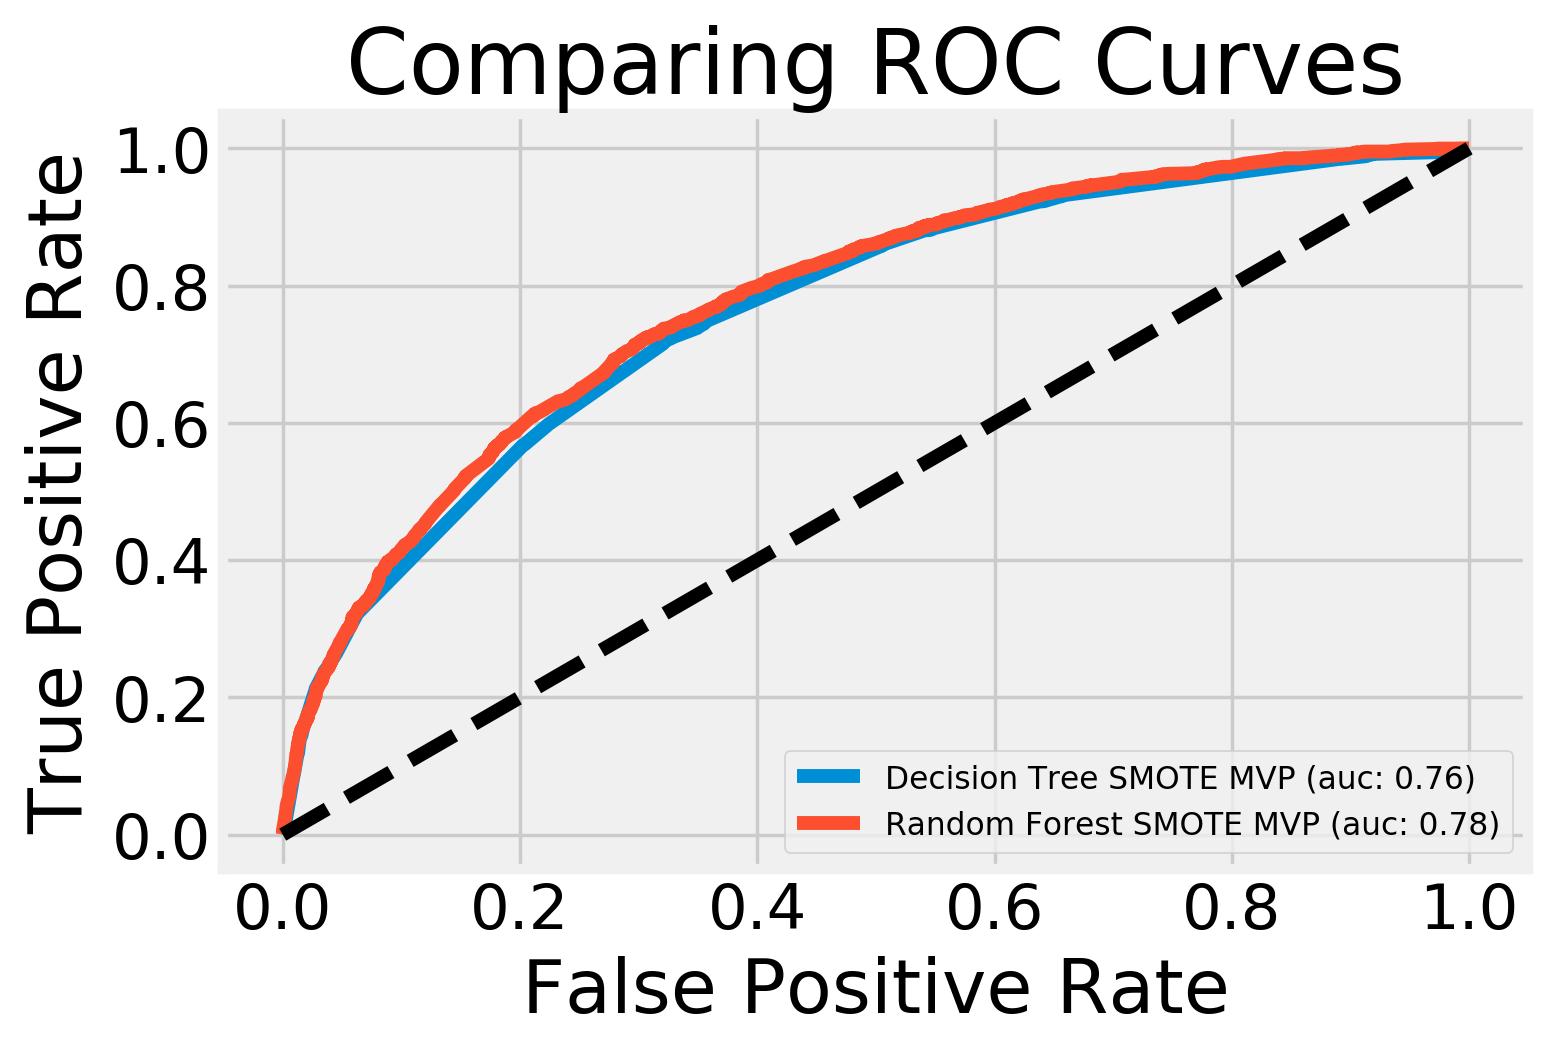

In [116]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

# REDO WITH LESS FEATURES

In [117]:
y = real_df['Was_Fatal']
X = real_df[['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'Flight_Purpose_Aerial Application',
       'Flight_Purpose_Business', 'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [118]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34803 entries, 72375 to 70075
Data columns (total 17 columns):
Season_Fall                          34803 non-null uint8
Season_Spring                        34803 non-null uint8
Season_Summer                        34803 non-null uint8
Season_Winter                        34803 non-null uint8
Flight_Purpose_Aerial Application    34803 non-null uint8
Flight_Purpose_Business              34803 non-null uint8
Flight_Purpose_Ferry                 34803 non-null uint8
Flight_Purpose_Instructional         34803 non-null uint8
Flight_Purpose_Other                 34803 non-null uint8
Flight_Purpose_Personal              34803 non-null uint8
Flight_Purpose_Positioning           34803 non-null uint8
Weather_Condition_IMC                34803 non-null uint8
Weather_Condition_VMC                34803 non-null uint8
Broad_Phase_of_Flight_INFLIGHT       34803 non-null uint8
Broad_Phase_of_Flight_LANDING        34803 non-null uint8
Broad_Phase_of_Fl

In [119]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted = pd.DataFrame(X_smoted, columns=['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI'])

y_smoted = pd.Series(y_smoted)

In [120]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted):
        
        kX_train = X_smoted.iloc[train_index]
        kX_test = X_smoted.iloc[test_index]
        ky_train = y_smoted.iloc[train_index]
        ky_test = y_smoted.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling -- less features')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling -- less features
LR accuracy: 0.4654 precision: 0.5753 recall: 0.6353 f1: 0.4508 fB: 0.5217

Scores with SMOTE Oversampling -- less features
KNN accuracy: 0.5664 precision: 0.6681 recall: 0.3238 f1: 0.3872 fB: 0.3405

Scores with SMOTE Oversampling -- less features
NB accuracy: 0.5931 precision: 0.6704 recall: 0.1701 f1: 0.2691 fB: 0.1994

Scores with SMOTE Oversampling -- less features
SVC accuracy: 0.469 precision: 0.5719 recall: 0.6515 f1: 0.461 fB: 0.534

Scores with SMOTE Oversampling -- less features
Decision Tree accuracy: 0.4781 precision: 0.5765 recall: 0.6427 f1: 0.4651 fB: 0.5326

Scores with SMOTE Oversampling -- less features
Random Forest accuracy: 0.4776 precision: 0.5768 recall: 0.6419 f1: 0.4642 fB: 0.5317

Scores with SMOTE Oversampling -- less features
Gradient Boosted Trees accuracy: 0.4743 precision: 0.5735 recall: 0.6482 f1: 0.4644 fB: 0.5343



In [121]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.5844060444941934, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
logistic: best score: 0.700643626696516, best estimator: LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.698439904855184, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.6980201483139779, best e

In [122]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.700643626696516, best estimator: LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [123]:
lm2 = grid.best_estimator_
lm2.fit(X_smoted, y_smoted)

LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [124]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = lm2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTED BALANCE -- Logistic Regress Less Features')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTED BALANCE -- Logistic Regress Less Features
Logistic Regress accuracy: 0.7011 precision: 0.6275 recall: 0.6714 f1: 0.6204 fB: 0.6422



In [125]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

coef_viewer = {}
for col, score in zip(columns, lm2.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Broad_Phase_of_Flight_INFLIGHT       0.305512
Broad_Phase_of_Flight_LANDING        1.968018
Broad_Phase_of_Flight_TAKEOFF        1.190738
Broad_Phase_of_Flight_TAXI           2.777551
Flight_Purpose_Aerial Application    2.085396
Flight_Purpose_Business              0.925963
Flight_Purpose_Ferry                 1.800601
Flight_Purpose_Instructional         1.701842
Flight_Purpose_Other                 1.203556
Flight_Purpose_Personal              1.017858
Flight_Purpose_Positioning           1.032345
Season_Fall                          0.139124
Season_Spring                        0.288047
Season_Summer                        0.318983
Season_Winter                        0.249798
Weather_Condition_IMC               -1.437909
Weather_Condition_VMC                0.425917
dtype: float64

In [126]:
from sklearn.metrics import fbeta_score

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []

y_predict = lm2.predict(X_FINALtest)

accuracy.append(accuracy_score(y_FINALtest, y_predict))
precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print(f'TEST Scores with SMOTE Logistic Regression Less Features')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

TEST Scores with SMOTE Logistic Regression Less Features
accuracy: 0.7079 precision: 0.3386 recall: 0.6673 f1: 0.4492 fB: 0.5588



In [127]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.700521197705331, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [128]:
rf3 = grid.best_estimator_
rf3.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [129]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES
RF MVP accuracy: 0.7031 precision: 0.6243 recall: 0.6869 f1: 0.6248 fB: 0.6522



In [130]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

feature_viewer = {}
for col, score in zip(columns, rf3.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Broad_Phase_of_Flight_INFLIGHT       0.293267
Broad_Phase_of_Flight_LANDING        0.124098
Broad_Phase_of_Flight_TAKEOFF        0.036184
Broad_Phase_of_Flight_TAXI           0.042809
Flight_Purpose_Aerial Application    0.037701
Flight_Purpose_Business              0.011073
Flight_Purpose_Ferry                 0.003609
Flight_Purpose_Instructional         0.027271
Flight_Purpose_Other                 0.010952
Flight_Purpose_Personal              0.026434
Flight_Purpose_Positioning           0.003224
Season_Fall                          0.004496
Season_Spring                        0.002923
Season_Summer                        0.004424
Season_Winter                        0.003946
Weather_Condition_IMC                0.168576
Weather_Condition_VMC                0.199014
dtype: float64

In [131]:
from sklearn.metrics import fbeta_score

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []

y_predict = rf3.predict(X_FINALtest)

accuracy.append(accuracy_score(y_FINALtest, y_predict))
precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print(f'TEST Scores with SMOTE RF Less Features')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

TEST Scores with SMOTE RF Less Features
accuracy: 0.6995 precision: 0.3328 recall: 0.6799 f1: 0.4468 fB: 0.5625



In [132]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.7000489715964741, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [133]:
dt2 = grid.best_estimator_
dt2.fit(X_smoted, y_smoted)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [134]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = dt2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES
RF MVP accuracy: 0.7021 precision: 0.6219 recall: 0.6917 f1: 0.625 fB: 0.6546



In [135]:
from sklearn.metrics import fbeta_score

models = [dt2, lm2, rf3]
names = ['Decision Tree SMOTE Less Features', 'LR SMOTE Less Features', 'Random Forest SMOTE Less Features']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores Less Features')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores Less Features
Decision Tree SMOTE Less Features accuracy: 0.6955 precision: 0.3302 recall: 0.6857 f1: 0.4457 fB: 0.5642

FINAL TEST Scores Less Features
LR SMOTE Less Features accuracy: 0.7079 precision: 0.3386 recall: 0.6673 f1: 0.4492 fB: 0.5588

FINAL TEST Scores Less Features
Random Forest SMOTE Less Features accuracy: 0.6995 precision: 0.3328 recall: 0.6799 f1: 0.4468 fB: 0.5625



In [136]:
feature_selection(X_smoted, y_smoted, 15)

,Feature_Importance,RFE
0,Weather_Condition_IMC,Season_Spring
1,Broad_Phase_of_Flight_LANDING,Season_Summer
2,Broad_Phase_of_Flight_INFLIGHT,Flight_Purpose_Aerial Application
3,Broad_Phase_of_Flight_TAXI,Flight_Purpose_Business
4,Broad_Phase_of_Flight_TAKEOFF,Flight_Purpose_Ferry
5,Flight_Purpose_Aerial Application,Flight_Purpose_Instructional
6,Flight_Purpose_Instructional,Flight_Purpose_Other
7,Weather_Condition_VMC,Flight_Purpose_Personal
8,Flight_Purpose_Personal,Flight_Purpose_Positioning
9,Flight_Purpose_Other,Weather_Condition_IMC


In [137]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

feature_viewer = {}
for col, score in zip(columns, rf3.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Broad_Phase_of_Flight_INFLIGHT       0.293267
Broad_Phase_of_Flight_LANDING        0.124098
Broad_Phase_of_Flight_TAKEOFF        0.036184
Broad_Phase_of_Flight_TAXI           0.042809
Flight_Purpose_Aerial Application    0.037701
Flight_Purpose_Business              0.011073
Flight_Purpose_Ferry                 0.003609
Flight_Purpose_Instructional         0.027271
Flight_Purpose_Other                 0.010952
Flight_Purpose_Personal              0.026434
Flight_Purpose_Positioning           0.003224
Season_Fall                          0.004496
Season_Spring                        0.002923
Season_Summer                        0.004424
Season_Winter                        0.003946
Weather_Condition_IMC                0.168576
Weather_Condition_VMC                0.199014
dtype: float64

In [138]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

models = [dt2, lm2, rf3]
names = ['Decision Tree SMOTE Less Features', 'LR SMOTE Less Features', 'Random Forest SMOTE Less Features']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted, y_smoted)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0.23315425 0.76684575]
 [0.23315425 0.76684575]
 [0.40973872 0.59026128]
 ...
 [0.61657298 0.38342702]
 [0.21657005 0.78342995]
 [0.21657005 0.78342995]]


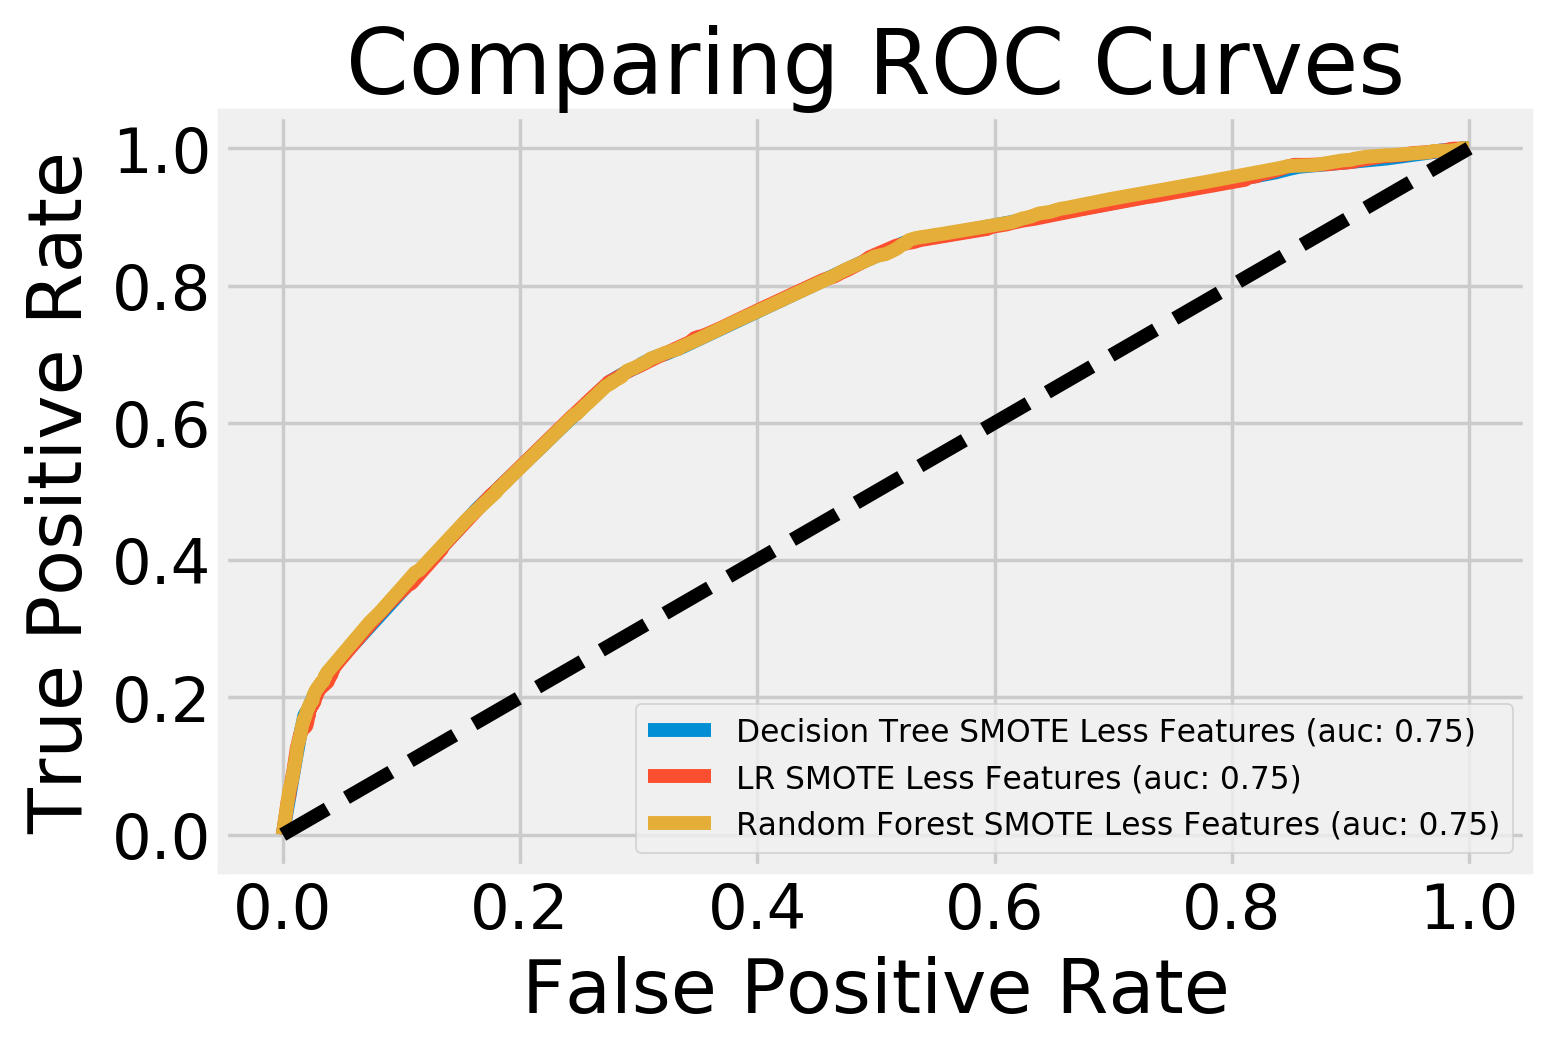

In [139]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

# REPEAT WITH EVEN LESS FEATURES

In [140]:
y = real_df['Was_Fatal']
X = real_df[['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [141]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34803 entries, 72375 to 70075
Data columns (total 17 columns):
Season_Fall                          34803 non-null uint8
Season_Spring                        34803 non-null uint8
Season_Summer                        34803 non-null uint8
Season_Winter                        34803 non-null uint8
Flight_Purpose_Aerial Application    34803 non-null uint8
Flight_Purpose_Business              34803 non-null uint8
Flight_Purpose_Ferry                 34803 non-null uint8
Flight_Purpose_Instructional         34803 non-null uint8
Flight_Purpose_Other                 34803 non-null uint8
Flight_Purpose_Personal              34803 non-null uint8
Flight_Purpose_Positioning           34803 non-null uint8
Weather_Condition_IMC                34803 non-null uint8
Weather_Condition_VMC                34803 non-null uint8
Broad_Phase_of_Flight_INFLIGHT       34803 non-null uint8
Broad_Phase_of_Flight_LANDING        34803 non-null uint8
Broad_Phase_of_Fl

In [142]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted_last = pd.DataFrame(X_smoted, columns=['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI'])

y_smoted_last = pd.Series(y_smoted)

In [143]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted_last):
        
        kX_train = X_smoted_last.iloc[train_index]
        kX_test = X_smoted_last.iloc[test_index]
        ky_train = y_smoted_last.iloc[train_index]
        ky_test = y_smoted_last.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling -- last features')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling -- last features
LR accuracy: 0.4654 precision: 0.5753 recall: 0.6353 f1: 0.4508 fB: 0.5217

Scores with SMOTE Oversampling -- last features
KNN accuracy: 0.5664 precision: 0.6681 recall: 0.3238 f1: 0.3872 fB: 0.3405

Scores with SMOTE Oversampling -- last features
NB accuracy: 0.5931 precision: 0.6704 recall: 0.1701 f1: 0.2691 fB: 0.1994

Scores with SMOTE Oversampling -- last features
SVC accuracy: 0.469 precision: 0.5719 recall: 0.6515 f1: 0.461 fB: 0.534

Scores with SMOTE Oversampling -- last features
Decision Tree accuracy: 0.4781 precision: 0.5765 recall: 0.6428 f1: 0.4651 fB: 0.5326

Scores with SMOTE Oversampling -- last features
Random Forest accuracy: 0.4761 precision: 0.5748 recall: 0.6457 f1: 0.4648 fB: 0.5336

Scores with SMOTE Oversampling -- last features
Gradient Boosted Trees accuracy: 0.4743 precision: 0.5735 recall: 0.6482 f1: 0.4644 fB: 0.5343



In [144]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.5844060444941934, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
logistic: best score: 0.700643626696516, best estimator: LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.6984573947110676, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.6981075975933958, best 

In [145]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.700643626696516, best estimator: LogisticRegression(C=81.11308307896873, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [146]:
lm3 = grid.best_estimator_
lm3.fit(X_smoted_last, y_smoted_last)

LogisticRegression(C=81.11308307896873, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [147]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = lm3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTED BALANCE -- Logistic Regress Last Features')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTED BALANCE -- Logistic Regress Last Features
Logistic Regress accuracy: 0.7011 precision: 0.6275 recall: 0.6714 f1: 0.6204 fB: 0.6422



In [148]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

coef_viewer = {}
for col, score in zip(columns, lm3.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Broad_Phase_of_Flight_INFLIGHT       0.523220
Broad_Phase_of_Flight_LANDING        2.185886
Broad_Phase_of_Flight_TAKEOFF        1.408433
Broad_Phase_of_Flight_TAXI           2.996719
Flight_Purpose_Aerial Application    2.335246
Flight_Purpose_Business              1.175252
Flight_Purpose_Ferry                 2.052417
Flight_Purpose_Instructional         1.951526
Flight_Purpose_Other                 1.453081
Flight_Purpose_Personal              1.267385
Flight_Purpose_Positioning           1.282152
Season_Fall                          0.125883
Season_Spring                        0.274798
Season_Summer                        0.305776
Season_Winter                        0.236559
Weather_Condition_IMC               -0.525881
Weather_Condition_VMC                1.337878
dtype: float64

In [149]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7002938295788442, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [150]:
rf4 = grid.best_estimator_
rf4.fit(X_smoted_last, y_smoted_last)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [151]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf4.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES
RF MVP accuracy: 0.7029 precision: 0.6241 recall: 0.687 f1: 0.6247 fB: 0.6521



In [152]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

feature_viewer = {}
for col, score in zip(columns, rf4.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Broad_Phase_of_Flight_INFLIGHT       0.251778
Broad_Phase_of_Flight_LANDING        0.158469
Broad_Phase_of_Flight_TAKEOFF        0.047129
Broad_Phase_of_Flight_TAXI           0.048342
Flight_Purpose_Aerial Application    0.033125
Flight_Purpose_Business              0.008735
Flight_Purpose_Ferry                 0.003817
Flight_Purpose_Instructional         0.032219
Flight_Purpose_Other                 0.010217
Flight_Purpose_Personal              0.026140
Flight_Purpose_Positioning           0.003150
Season_Fall                          0.004557
Season_Spring                        0.003543
Season_Summer                        0.005171
Season_Winter                        0.003898
Weather_Condition_IMC                0.199140
Weather_Condition_VMC                0.160571
dtype: float64

In [153]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.7000314817405905, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [154]:
dt3 = grid.best_estimator_
dt3.fit(X_smoted_last, y_smoted_last)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [155]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = dt3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES
RF MVP accuracy: 0.7021 precision: 0.6219 recall: 0.6917 f1: 0.625 fB: 0.6546



In [156]:
predict_y_smoted_last = rf4.predict(X_smoted_last)

In [157]:
import collections

collections.Counter(predict_y_smoted_last)

Counter({'Fatal': 27978, 'Non-fatal': 29198})

In [158]:
collections.Counter(y_smoted_last)

Counter({'Fatal': 28588, 'Non-fatal': 28588})

(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.839


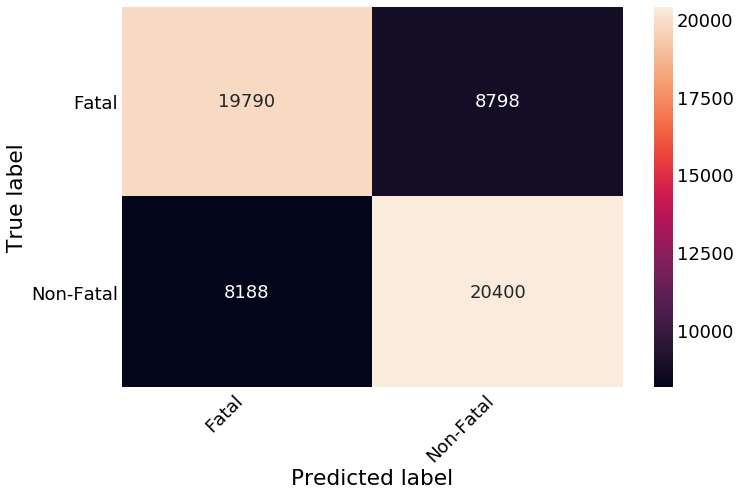

In [159]:
#Checking accuracy score on smoted model
from sklearn.metrics import confusion_matrix

RF_cross_val = cross_val_score(rf4, X_train, y_train, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_last = confusion_matrix(y_smoted_last, predict_y_smoted_last)
RF_smoted_last = print_confusion_matrix(RF_smoted_last, ['Fatal', 'Non-Fatal'])

In [160]:
models = [dt3, lm3, rf4]
names = ['Decision Tree SMOTE Last Features', 'LR SMOTE Last Features', 'Random Forest SMOTE Last Features']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores Last Features')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores Last Features
Decision Tree SMOTE Last Features accuracy: 0.6955 precision: 0.3302 recall: 0.6857 f1: 0.4457 fB: 0.5642

FINAL TEST Scores Last Features
LR SMOTE Last Features accuracy: 0.7079 precision: 0.3386 recall: 0.6673 f1: 0.4492 fB: 0.5588

FINAL TEST Scores Last Features
Random Forest SMOTE Last Features accuracy: 0.6994 precision: 0.3328 recall: 0.6803 f1: 0.4469 fB: 0.5628



In [161]:
feature_selection(X_smoted_last, y_smoted_last, 15)

,Feature_Importance,RFE
0,Weather_Condition_IMC,Season_Spring
1,Broad_Phase_of_Flight_LANDING,Season_Summer
2,Broad_Phase_of_Flight_INFLIGHT,Flight_Purpose_Aerial Application
3,Broad_Phase_of_Flight_TAXI,Flight_Purpose_Business
4,Weather_Condition_VMC,Flight_Purpose_Ferry
5,Broad_Phase_of_Flight_TAKEOFF,Flight_Purpose_Instructional
6,Flight_Purpose_Instructional,Flight_Purpose_Other
7,Flight_Purpose_Aerial Application,Flight_Purpose_Personal
8,Flight_Purpose_Personal,Flight_Purpose_Positioning
9,Flight_Purpose_Other,Weather_Condition_IMC


In [162]:
models = [dt3, lm3, rf4]
names = ['Decision Tree SMOTE Last Features', 'LR SMOTE Last Features', 'Random Forest SMOTE Last Features']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted_last, y_smoted_last)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0.23411066 0.76588934]
 [0.23411066 0.76588934]
 [0.40964013 0.59035987]
 ...
 [0.61813563 0.38186437]
 [0.21381433 0.78618567]
 [0.21381433 0.78618567]]


Text(0.5,1,'Comparing ROC Curves')

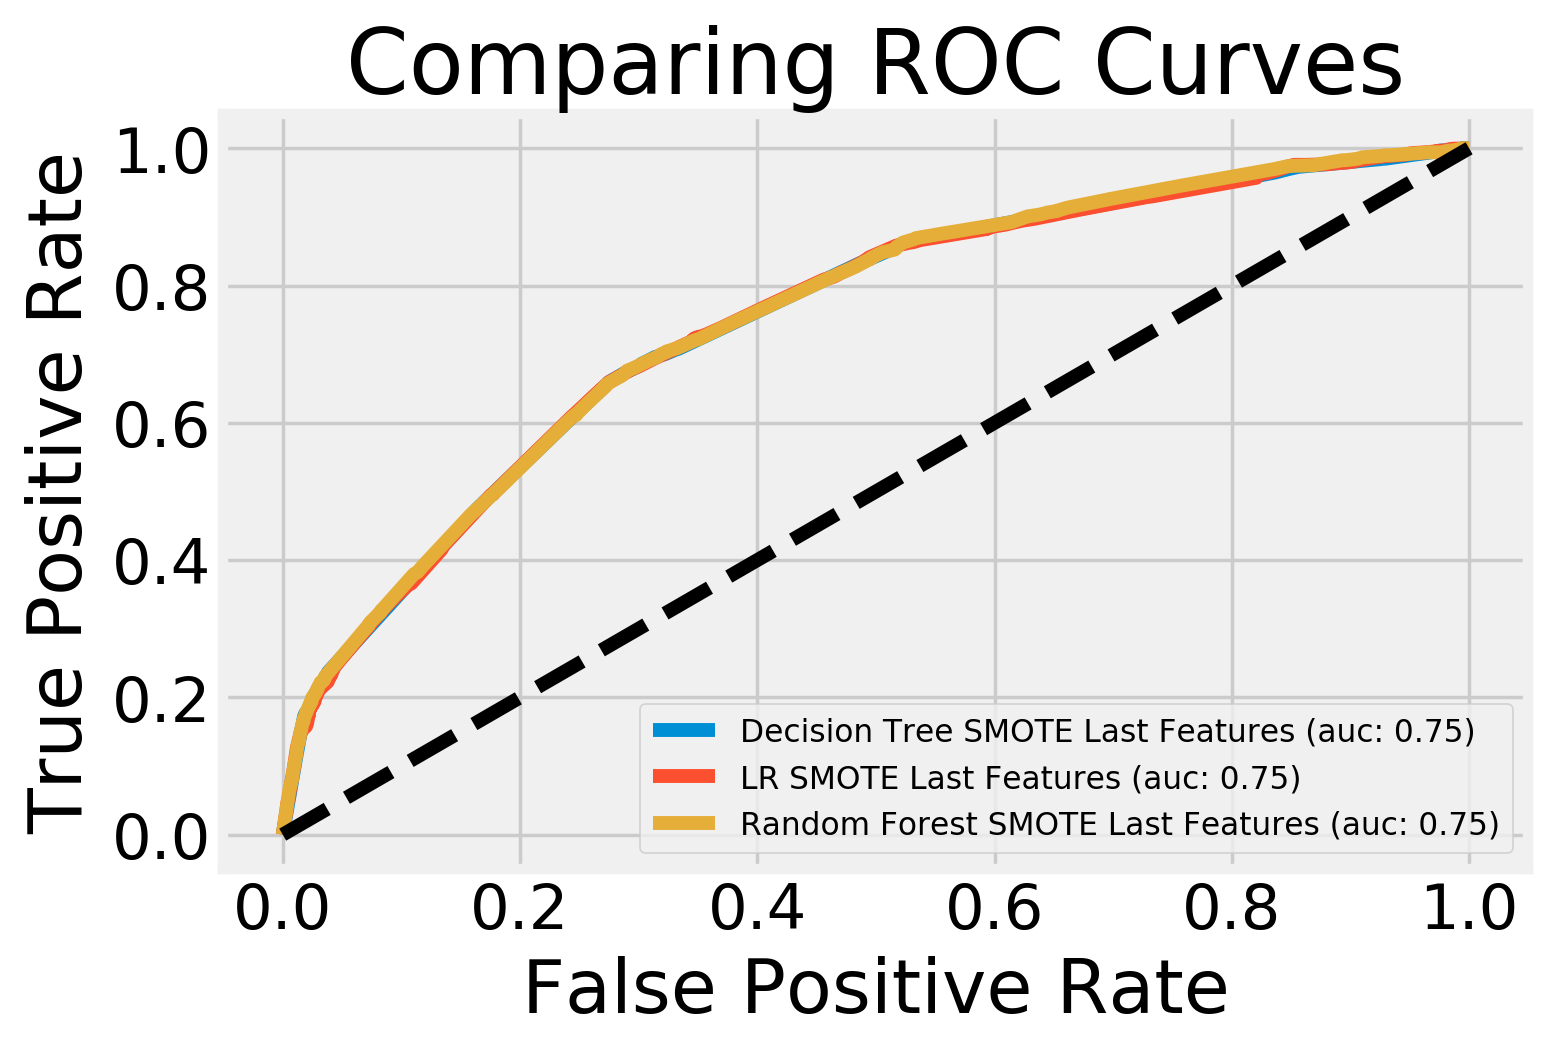

In [163]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves")

In [164]:
predict_y_FINALtest = rf4.predict(X_FINALtest)

In [165]:
collections.Counter(predict_y_FINALtest)

Counter({'Fatal': 4235, 'Non-fatal': 7366})

In [166]:
collections.Counter(y_FINALtest)

Counter({'Fatal': 2071, 'Non-fatal': 9530})

(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.835


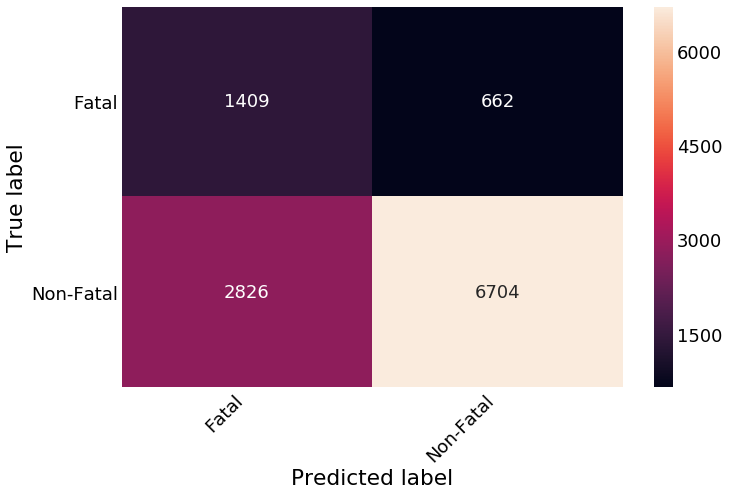

In [167]:
#Checking final accuracy of model

RF_cross_val = cross_val_score(rf4, X_FINALtest, y_FINALtest, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_last = confusion_matrix(y_FINALtest, predict_y_FINALtest)
RF_smoted_last = print_confusion_matrix(RF_smoted_last, ['Fatal', 'Non-Fatal'])